In [1]:
%%HTML
<style> code {background-color : orange !important;} </style>

In [2]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window (note it may show up behind your browser)
# Make some of the relevant imports
import cv2 # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio

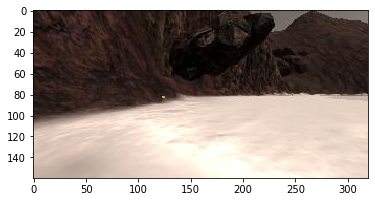

In [3]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)
# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

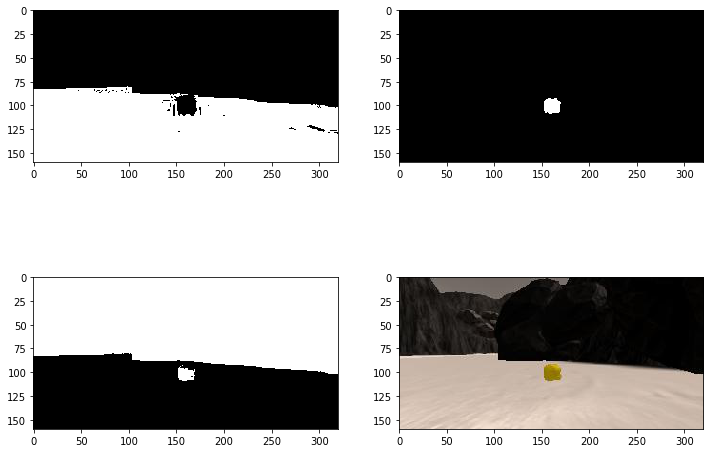

In [5]:
# In the simulator you can toggle on a grid on the ground for calibration
# You can also toggle on the rock samples with the 0 (zero) key.  
# Here's an example of the grid and one of the rocks
example_grid = '../calibration_images/example_grid1.jpg'
example_rock = '../calibration_images/example_rock1.jpg'
grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)
def color_thresh(img, rgb_thresh=(160, 160, 160, 100 , 100,50)):
    # Create an array of zeros same xy size as img, but single channel
    color_select_path = np.zeros_like(img[:,:,0])
    color_select_rock = np.zeros_like(img[:,:,0])
    color_select_obstacle = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    yellow_thresh = (img[:,:,0] > rgb_thresh[3] ) \
                & (img[:,:,1] > rgb_thresh[4] ) \
                & (img[:,:,2] < rgb_thresh[5] )
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select_path[above_thresh] = 1
    color_select_rock[yellow_thresh] = 1
    color_select_obstacle[below_thresh] = 1
    # Return the binary image
    return color_select_path, color_select_rock, color_select_obstacle

threshed_path, threshed_rock, threshed_obs = color_thresh(rock_img)
#plt.imshow(threshed, )
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(threshed_path,cmap='gray')
plt.subplot(222)
plt.imshow(threshed_rock,cmap='gray')
plt.subplot(223)
plt.imshow(threshed_obs, cmap='gray')
#fig = plt.figure(figsize=(12,3))
plt.subplot(224)
#plt.imshow(grid_img)
#plt.subplot(122)
plt.imshow(rock_img)

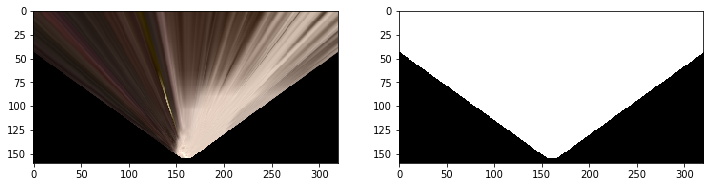

In [6]:
# Define a function to perform a perspective transform
# I've used the example grid image above to choose source points for the
# grid cell in front of the rover (each grid cell is 1 square meter in the sim)
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):
           
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))# keep same size as input image
    outView = cv2.warpPerspective(np.ones_like(img[:,:,0]), M, (img.shape[1], img.shape[0]))
    return warped, outView


# Define calibration box in source (actual) and destination (desired) coordinates
# These source and destination points are defined to warp the image
# to a grid where each 10x10 pixel square represents 1 square meter
# The destination box will be 2*dst_size on each side
dst_size = 5 
# Set a bottom offset to account for the fact that the bottom of the image 
# is not the position of the rover but a bit in front of it
# this is just a rough guess, feel free to change it!
bottom_offset = 6
source = np.float32([[14, 140], [301 ,140],[200, 96], [118, 96]])
destination = np.float32([[image.shape[1]/2 - dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - bottom_offset],
                  [image.shape[1]/2 + dst_size, image.shape[0] - 2*dst_size - bottom_offset], 
                  [image.shape[1]/2 - dst_size, image.shape[0] - 2*dst_size - bottom_offset],
                  ])
warped, outView = perspect_transform(image, source, destination)
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(warped)
plt.subplot(122)
plt.imshow(outView, cmap='gray')
#scipy.misc.imsave('../output/warped_example.jpg', warped)

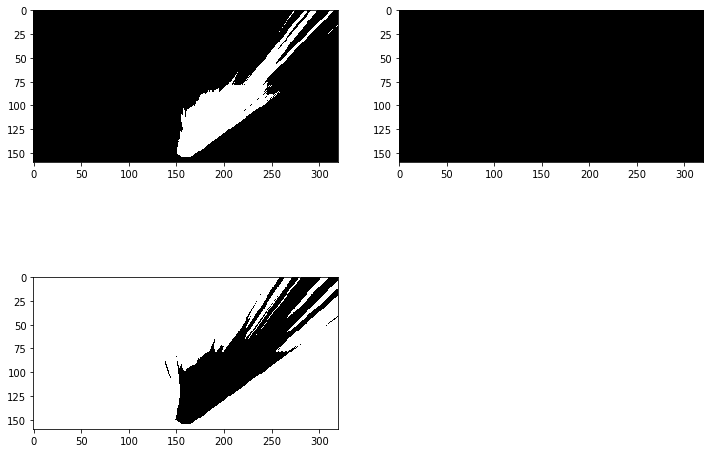

In [7]:
# Identify pixels above the threshold
# Threshold of RGB > 160 does a nice job of identifying ground pixels only
def color_thresh(img, rgb_thresh=(160, 160, 160, 100 , 100,50)):
    # Create an array of zeros same xy size as img, but single channel
    color_select_path = np.zeros_like(img[:,:,0])
    color_select_rock = np.zeros_like(img[:,:,0])
    color_select_obstacle = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    between_thresh = (img[:,:,0] > rgb_thresh[3] ) \
                & (img[:,:,1] > rgb_thresh[4] ) \
                & (img[:,:,2] < rgb_thresh[5] )
    below_thresh = (img[:,:,0] < rgb_thresh[0]) \
                & (img[:,:,1] < rgb_thresh[1]) \
                & (img[:,:,2] < rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select_path[above_thresh] = 1
    color_select_rock[between_thresh] = 1
    color_select_obstacle[below_thresh] = 1
    # Return the binary image
    return color_select_path, color_select_rock, color_select_obstacle

threshed_path, threshed_rock, threshed_obs = color_thresh(warped)
#plt.imshow(threshed, )
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(threshed_path,cmap='gray')
plt.subplot(222)
plt.imshow(threshed_rock,cmap='gray')
plt.subplot(223)
plt.imshow(threshed_obs, cmap='gray')
#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

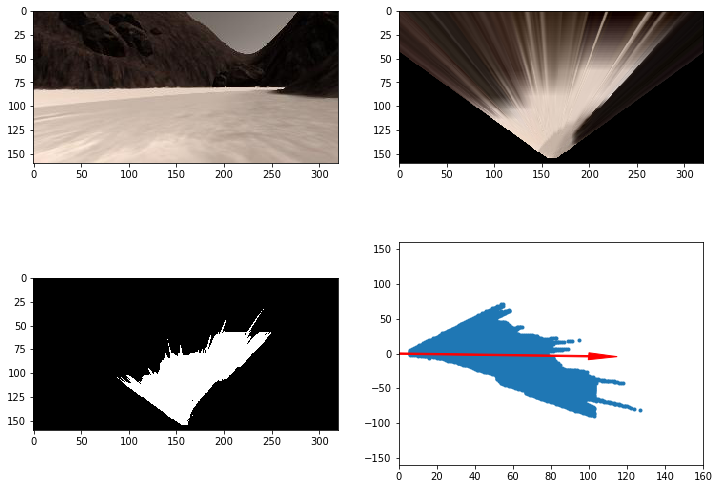

In [9]:
#Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel

# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world

# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped, outView = perspect_transform(image, source, destination)
threshed_path, threshed_rock, threshed_obs = color_thresh(warped)

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = rover_coords(threshed_path)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshed_path, cmap='gray')
plt.subplot(224)
plt.plot(xpix, ypix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)

In [10]:
# Import pandas and read in csv file as a dataframe
import pandas as pd
# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)

# Creating a class to be the data container
# Will read in saved data from csv file and populate this object
# Worldmap is instantiated as 200 x 200 grids corresponding 
# to a 200m x 200m space (same size as the ground truth map: 200 x 200 pixels)
# This encompasses the full range of output position values in x and y from the sim
class Databucket():
    def __init__(self):
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0 # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d # Ground truth worldmap

# Instantiate a Databucket().. this will be a global variable/object
# that you can refer to in the process_image() function below
data = Databucket()

In [11]:
# Define a function to pass stored images to
# reading rover position and yaw angle from csv file
# This function will be used by moviepy to create an output video
def process_image(img):
    # Example of how to use the Databucket() object defined above
    # to print the current x, y and yaw values 
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])
    dst_size = 8

    # TODO: 
    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    warped, mask = perspect_transform(img, source, destination)
    # 3) Apply color threshold to identify navigable terrain/obstacles/rock samples
    threshed_path, threshed_rock, threshed_obs = color_thresh(warped)
    obstacles_world = np.absolute(np.float32(threshed_obs))*mask
    # 4) Convert thresholded image pixel values to rover-centric coords
    xpix, ypix = rover_coords(threshed_path)
    
    # 5) Convert rover-centric pixel values to world coords
    world_size = data.worldmap.shape[0]
    scale = 2*dst_size
    xpos = data.xpos[data.count]
    ypos = data.ypos[data.count]
    yaw = data.yaw[data.count]
    x_world, y_world = pix_to_world(xpix,ypix,xpos,ypos,yaw,world_size,scale)
    
    obs_xpix, obs_ypix = rover_coords(obstacles_world)
    obs_xworld, obs_yworld = pix_to_world(obs_xpix,obs_ypix,xpos,ypos,yaw,world_size,scale)
    
    rock_xpix, rock_ypix = rover_coords(threshed_rock)
    rock_xworld, rock_yworld = pix_to_world(rock_xpix,rock_ypix,xpos,ypos,yaw,world_size,scale)
    # 6) Update worldmap (to be displayed on right side of screen)
        
    data.worldmap[y_world, x_world,2] = 255
    data.worldmap[obs_yworld,obs_xworld,0] = 255
    
    data.worldmap[rock_yworld,rock_xworld,1] = 255
    
    #below, these two methods prevent the obstacle areas to overwrite the path area.
    nav_pix = data.worldmap[:,:,2] > 0
    data.worldmap[nav_pix, 0] = 0


    # 7) Make a mosaic image, below is some example code
        # First create a blank image (can be whatever shape you like)
    output_image = np.zeros((img.shape[0] + data.worldmap.shape[0], img.shape[1]*2, 3))
        # Next you can populate regions of the image with various output
        # Here I'm putting the original image in the upper left hand corner
    output_image[0:img.shape[0], 0:img.shape[1]] = img

        # Let's create more images to add to the mosaic, first a warped image
    warped, mask = perspect_transform(img, source, destination)
        # Add the warped image in the upper right hand corner
    output_image[0:img.shape[0], img.shape[1]:] = warped

        # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)
        # Flip map overlay so y-axis points upward and add to output_image 
    output_image[img.shape[0]:, 0:data.worldmap.shape[1]] = np.flipud(map_add)


        # Then putting some text over the image
    cv2.putText(output_image,"Populate this image with your analyses to make a video!", (20, 20), 
                cv2.FONT_HERSHEY_COMPLEX, 0.4, (255, 255, 255), 1)
    if data.count < len(data.images) - 1:
        data.count += 1 # Keep track of the index in the Databucket()
    
    return output_image

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip


# Define pathname to save the output video
output = '../output/test_mapping.mp4'
data = Databucket() # Re-initialize data in case you're running this cell multiple times
clip = ImageSequenceClip(data.images, fps=25) # Note: output video will be sped up because 
                                          # recording rate in simulator is fps=25
new_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time new_clip.write_videofile(output, audio=False)

Moviepy - Building video ../output/test_mapping.mp4.
Moviepy - Writing video ../output/test_mapping.mp4



Moviepy - Done !
Moviepy - video ready ../output/test_mapping.mp4
Wall time: 8.04 s


In [13]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))